<a href="https://colab.research.google.com/github/Diddi-RamaKrishna/Optimisation-for-Renewable-Energy-Modelling/blob/main/Optimisation_of_Wind%2C_Solar_and_Battery_for_FDRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Optimisation is based on Genetic Algorithm.
Minimising the following

1.   Cost
2.   Energy Loss


*  Maximising DFR (Demand Fulfillment Ration)





In [ ]:
!pip install deap matplotlib
!pip install geneticalgorithm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15080 sha256=29e461a59dd5d887e17fb0cd26414cd7eeb268e9a6c232cdf337fe3680e19ddf
  Stored in directory: /root/.cache/pip/wheels/3f/83/19/b5552bb9630e353f7c5b15be44bf10900afe1abbbfcf536afd
Successfully built func-timeout


In [ ]:
import numpy as np
import pandas as pd
from google.colab import files

# Upload the Excel file
uploaded = files.upload()

# Get the filename
filename = list(uploaded.keys())[0]

# Read the Excel file into a DataFrame
df = pd.read_excel(filename)

year = np.array(df.iloc[1:, 0])
month = np.array(df.iloc[1:, 1])
day = np.array(df.iloc[1:, 2])
time_values = np.array([time.strftime('%H:%M') for time in df.iloc[1:, 3]])
wind_profile = np.array(df.iloc[1:, 4], dtype=float)
solar_profile = np.array(df.iloc[1:, 5], dtype=float)

Saving Book123553.xlsx to Book123553.xlsx


In [ ]:
planted_capacity = 300
battery_efficiency = 0.8 #let battery has 80% efficiency , over the course you can set a logic where it decreases. for now the degrading can be ignored.

In [ ]:
# @title energy_management
import numpy as np
import time
def energy_management(time_values,generation,a, planted_capacity, battery_soc, battery_efficiency):
    start_time = time.time()
    # Pre-compute constants
    demand_values=np.where(np.isin(time_values, a), 300.0, 0.0)
    efficiency_loss_factor = (1 - battery_efficiency) * 5 / 4
    max_charge_capacity = planted_capacity * battery_soc
    # Calculate immediate generation and demand relationships
    generation_to_evacuate = np.minimum(generation, demand_values)
    deficit_values = np.maximum(0, demand_values - generation_to_evacuate)
    excess_energy_values = np.maximum(0, generation - demand_values)
    # Cumulative charging handling
    cumulative_charge_list = np.zeros_like(demand_values)
    cumulative_charging = 0
    for i in range(len(demand_values)):
        possible_charge = cumulative_charging + excess_energy_values[i]
        temp_value = min(possible_charge, max_charge_capacity)
        temp_value -= deficit_values[i] * (1 + efficiency_loss_factor)
        cumulative_charging = max(0, temp_value)
        cumulative_charge_list[i] = cumulative_charging
    # Hourly storage changes
    hourly_storage_results = np.where(
        (cumulative_charge_list == np.roll(cumulative_charge_list, 1)) &
        (cumulative_charge_list == max_charge_capacity),
        0,
        np.minimum(max_charge_capacity - np.roll(cumulative_charge_list, 1), excess_energy_values))
    # Withdrawal from storage
    withdrawal_from_storage_list = np.where(
        cumulative_charge_list > (np.roll(cumulative_charge_list, 1) + deficit_values),
        deficit_values,
        battery_efficiency * (np.roll(cumulative_charge_list, 1) - cumulative_charge_list + hourly_storage_results))
    # Calculating storage loss due to inefficiency
    storage_loss_list = withdrawal_from_storage_list * efficiency_loss_factor
    # Calculate excess energy after accounting for hourly storage
    excess_after_battery = np.maximum(0, excess_energy_values - hourly_storage_results)
    evacuated_post_charging_list = np.minimum(
        planted_capacity - (generation_to_evacuate + withdrawal_from_storage_list), excess_after_battery)
    evacuated_post_charging_list = np.where(
        (generation_to_evacuate + withdrawal_from_storage_list) < planted_capacity,
        evacuated_post_charging_list,
        0)
    # Final loss calculation
    final_loss_list = np.maximum(excess_after_battery - evacuated_post_charging_list, 0)
    DFR_without_MarketPurchase_list = np.where(
        demand_values > 0,
        (generation_to_evacuate + withdrawal_from_storage_list + evacuated_post_charging_list) / planted_capacity,
        0
    )
    loss_1_list = np.where(
        (generation_to_evacuate + withdrawal_from_storage_list + evacuated_post_charging_list + final_loss_list) <= planted_capacity,
        final_loss_list,
        planted_capacity - (generation_to_evacuate + withdrawal_from_storage_list + evacuated_post_charging_list)
    )
    loss_2_list = np.maximum(final_loss_list - loss_1_list, 0)
    '''print(f"Execution time: {time.time() - start_time:.2f} ms")
    print(f"Length of generation list: {len(generation)}")'''
    return {
        "Demand Values": demand_values,
        "Generation to Evacuate": generation_to_evacuate,
        "Deficit Values": deficit_values,
        "Excess Energy Values": excess_energy_values,
        "Cumulative Charge List": cumulative_charge_list,
        "Hourly Storage Results": hourly_storage_results,
        "Withdrawal from Storage List": withdrawal_from_storage_list,
        "Storage Loss List": storage_loss_list,
        "Excess After Battery": excess_after_battery,
        "Evacuated Post Charging List": evacuated_post_charging_list,
        "Final Loss List": final_loss_list,
        "DFR without Market Purchase": DFR_without_MarketPurchase_list,
        "Loss 1 List": loss_1_list,
        "Loss 2 List": loss_2_list }

 The best solution found:
 [4.55511087e+02 3.74700826e+02 2.73223862e-01 4.59730642e+00
 4.41380294e+00]

 Objective function:
 -2.4501222746996825


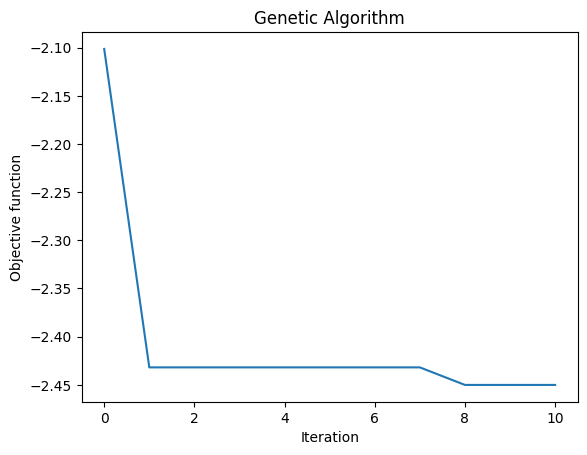

Optimal values: [4.41421755e+02 4.64975171e+02 2.93533950e-01 3.64717604e+00
 4.57314569e+00]


In [ ]:
# @title Optimising using GA with maximsing DFR
import numpy as np
from geneticalgorithm import geneticalgorithm as ga

def calculate_weight(dfr_values):
    # Calculate weights based on deviation from 0.9
    weights = np.exp(-np.abs(np.array(dfr_values) - 0.9) * 10)  # Exponential function to assign higher weights to values closer to 0.9
    return weights / np.sum(weights)  # Normalize weights to sum up to 1

def objective_function(x):
    # Unpack the input array into individual parameters
    wind_capacity, solar_capacity, battery_soc, q_index, r_index = x

    # Calculate hourly wind and solar generation
    hourly_wind_generation = (wind_profile * wind_capacity) / 50
    hourly_solar_generation = (solar_profile * solar_capacity) / 50
    combined_generation = np.add(hourly_wind_generation, hourly_solar_generation)

    # Create lists of consecutive time intervals for q and r
    q_times = [f'{i:02d}:00' for i in range(5 + int(q_index), min(12, 5 + int(q_index) + 2))]  # Restrict to two consecutive values
    r_times = [f'{i:02d}:00' for i in range(17 + int(r_index), min(24, 17 + int(r_index) + 2))]  # Restrict to two consecutive values

    # Combine q and r time intervals
    time_intervals = q_times + r_times

    # Run energy management function with given parameters
    results = energy_management(time_values, combined_generation, time_intervals, planted_capacity, battery_soc, battery_efficiency)

    # Filter out zero DFR values
    dfr_values = results['DFR without Market Purchase']

    nonzero_dfr_values = [dfr for dfr in dfr_values if dfr != 0]

    # Calculate median DFR value
    median_dfr = np.median(nonzero_dfr_values)

    # Calculate the 25th percentile DFR value
    percentile_dfr = np.percentile(nonzero_dfr_values, 25)

    # Calculate weights based on deviation from 0.9
    weights = calculate_weight(nonzero_dfr_values)

    # Calculate weighted average DFR for non-zero values
    weighted_avg_dfr = np.average(nonzero_dfr_values, weights=weights)

    # Combine metrics to create composite objective
    composite_objective = (median_dfr - abs(median_dfr - 0.9)) + (percentile_dfr - abs(percentile_dfr - 0.9)) + (weighted_avg_dfr - abs(weighted_avg_dfr - 0.9))

    return -composite_objective  # Minimize the negative of the composite objective

# Optimization function
def optimize_energy_model():
    varbound = np.array([[0, 500], [0, 500], [0.2, 0.3], [0, 5], [0, 5]])  # Variable bounds for each parameter
    algorithm_param = {
        'max_num_iteration': 10,
        'population_size': 15,
        'mutation_probability': 0.75,  # Increase mutation probability
        'parents_portion': 0.5,
        'crossover_probability': 0.8,
        'mutation_strength': 0.03,
        'elit_ratio': 0.1,
        'crossover_type': 'uniform',
        'max_iteration_without_improv': 150  # Set a limit to avoid infinite looping
    }

    model = ga(function=objective_function, dimension=5, variable_type='real', variable_boundaries=varbound, algorithm_parameters=algorithm_param)
    model.run()
    return model.output_dict['variable']

# Run optimization
best_values_a = optimize_energy_model()
print("Optimal values:", best_values)


 The best solution found:
 [4.81421930e+02 2.35341705e+02 2.30405838e-01 4.42178692e+00
 4.81537705e+00]

 Objective function:
 -62.94695000785399


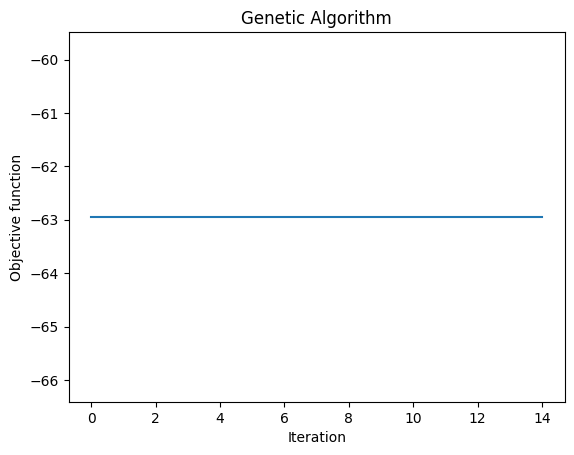

Optimal values: [4.41421755e+02 4.64975171e+02 2.93533950e-01 3.64717604e+00
 4.57314569e+00]


In [ ]:
# @title Optimisng in GA with minimising COST and Final loss
import numpy as np
from geneticalgorithm import geneticalgorithm as ga

# Define energy management function (energy_management) and other required functions here

def objective_function_2(x):
    """

    Args:
      x:

    Returns:

    """
    # Unpack the input array into individual parameters
    wind_capacity, solar_capacity, battery_soc, q_index, r_index = x

    # Calculate total cost of the wind power system
    cost_wind = wind_capacity * 5  # Cost per MW for wind is 5 crore INR

    # Calculate total cost of the solar power system
    cost_solar = solar_capacity * 3  # Cost per MW for solar is 3 crore INR

    # Combine the costs of the wind and solar power systems
    total_cost = cost_wind + cost_solar

    # Calculate a cost penalty to encourage lower costs
    cost_penalty = total_cost*0.0002  # Adjust the weight of the cost penalty relative to other objectives

    # Calculate hourly wind and solar generation
    hourly_wind_generation = (wind_profile * wind_capacity) / 50
    hourly_solar_generation = (solar_profile * solar_capacity) / 50
    combined_generation = np.add(hourly_wind_generation, hourly_solar_generation)

    # Create lists of consecutive time intervals for q and r
    q_times = [f'{i:02d}:00' for i in range(5 + int(q_index), min(12, 5 + int(q_index) + 2))]  # Restrict to two consecutive values
    r_times = [f'{i:02d}:00' for i in range(17 + int(r_index), min(24, 17 + int(r_index) + 2))]  # Restrict to two consecutive values

    # Combine q and r time intervals
    time_intervals = q_times + r_times

    # Run energy management function with given parameters
    results = energy_management(time_values, combined_generation, time_intervals, planted_capacity, battery_soc, battery_efficiency)

    # Filter out zero DFR values
    dfr_values = results['DFR without Market Purchase']
    nonzero_dfr_values = [dfr for dfr in dfr_values if dfr != 0]

    # Calculate median DFR value
    median_dfr = np.median(nonzero_dfr_values)

    # Calculate the 25th percentile DFR value
    percentile_dfr = np.percentile(nonzero_dfr_values, 25)

    # Calculate weights based on deviation from 0.9
    weights = calculate_weight(nonzero_dfr_values)

    # Calculate weighted average DFR for non-zero values
    weighted_avg_dfr = np.average(nonzero_dfr_values, weights=weights)

    # Calculate final loss
    final_loss_values = results['Final Loss List']
    median_final_loss = np.median(final_loss_values)  # Use median instead of mean

    # Calculate final loss penalty
    final_loss_penalty = abs(median_final_loss - 60)  # Penalize deviation from the target final loss of 60

    # Combine metrics to create composite objective with cost penalty and final loss penalty
    composite_objective = [(median_dfr - abs(median_dfr - 0.9)) + (percentile_dfr - abs(percentile_dfr - 0.9)) + (weighted_avg_dfr - abs(weighted_avg_dfr - 0.9))] + cost_penalty + final_loss_penalty

    return -composite_objective  # Minimize the negative of the composite objective

def optimize_energy_model_2():
    varbound = np.array([[0, 500], [0, 500], [0.2, 0.3], [0, 5], [0, 5]])  # Variable bounds for each parameter
    algorithm_param = {
        'max_num_iteration': 14,
        'population_size': 15,
        'mutation_probability': 0.75,  # Increase mutation probability
        'parents_portion': 0.5,
        'crossover_probability': 0.8,
        'mutation_strength': 0.03,
        'elit_ratio': 0.1,
        'crossover_type': 'uniform',
        'max_iteration_without_improv': 150  # Set a limit to avoid infinite looping
    }

    model = ga(function=objective_function_2, dimension=5, variable_type='real', variable_boundaries=varbound, algorithm_parameters=algorithm_param)
    model.run()
    return model.output_dict['variable']

# Run optimization
best_values_b = optimize_energy_model_2()
print("Optimal values:", best_values)

In [ ]:
# @title Decode the Results from GA algorithm
import numpy as np

def compute_correlation(array1, array2):
    correlation = np.corrcoef(array1, array2)[0, 1]
    return correlation

def calculate_penalty(dfr_values):
    total_penalty = 0

    for dfr in dfr_values:
        if dfr < 0.9:
            penalty_factor = 1 * (0.9 - dfr)  # Penalty factor increases linearly with deviation from 0.9
            total_penalty += penalty_factor

    return total_penalty
def print_optimal_results(best_values):
    wind_capacity, solar_capacity, battery_soc, q_index, r_index = best_values
    # Calculate hourly wind and solar generation
    hourly_wind_generation = (wind_profile * wind_capacity) / 50
    hourly_solar_generation = (solar_profile * solar_capacity) / 50
    combined_generation = np.add(hourly_wind_generation, hourly_solar_generation)
    # Round the indices to the nearest integer
    q_rounded = int(q_index + 0.5) if q_index % 1 >= 0.5 else int(q_index)
    r_rounded = int(r_index + 0.5) if r_index % 1 >= 0.5 else int(r_index)

    # Create lists of consecutive time intervals for q and r
    q_times = [f'{i:02d}:00' for i in range(5 + q_rounded, min(12, 5 + q_rounded + 2))]  # Restrict to two consecutive values
    r_times = [f'{i:02d}:00' for i in range(17 + r_rounded, min(24, 17 + r_rounded + 2))]  # Restrict to two consecutive values

    # Combine q and r time intervals
    time_intervals = q_times + r_times

    # Run energy management function with given parameters
    results = energy_management(time_values, combined_generation, time_intervals, planted_capacity, battery_soc, battery_efficiency)
    #correlation_demand_cumulative_charge = compute_correlation(results['Excess Energy Values'], results['Cumulative Charge List'])
    #print("Correlation between demand and cumulative charge list:", correlation_demand_cumulative_charge)
    # Extract DFR values
    dfr_values = results['DFR without Market Purchase']
    # Remove zero DFR values before calculating mean
    nonzero_dfr_values = [dfr for dfr in dfr_values if dfr != 0]
    penalty = calculate_penalty(nonzero_dfr_values)
    # Calculate mean DFR for non-zero values
    if len(nonzero_dfr_values) > 0:
        dfr = np.mean(nonzero_dfr_values)
    else:
        dfr = 0  # If all values are zero, set DFR to zero
    # Calculate total cost
    cost_wind = wind_capacity * 5  # Cost per MW for wind is 5 crore INR
    cost_solar = solar_capacity * 3  # Cost per MW for solar is 3 crore INR
      # Total cost in crore INR
    battery_cost=300*battery_soc*4
    total_cost = cost_wind + cost_solar+battery_cost
    # Create a dictionary to store the results
    optimal_results = {
        "Optimal Time Intervals": time_intervals,
        "Optimal DFR": dfr,
        "wind":wind_capacity,
        "solar":solar_capacity,
        "battery":battery_soc,
        "Penalty": penalty,
        "Total Cost": total_cost
    }

    return optimal_results
from tabulate import tabulate

# Define the optimal results for each set of values
best_values_1 = [500, 335, 0.25, 2, 1]
best_values_2 = best_values_a
best_values_3=best_values_b

result_1 = print_optimal_results(best_values_1)
result_2 = print_optimal_results(best_values_2)
result_3=print_optimal_results(best_values_3)
# Combine the results into a list of dictionaries
results = [result_1, result_2,result_3]

# Extract the keys (table headers) from the first dictionary
headers = list(result_1.keys())

# Extract the values (table rows) from all dictionaries
rows = [list(result.values()) for result in results]

# Print the table using tabulate
print(tabulate(rows, headers=headers, tablefmt="grid"))
print('Penality  reduced : ',result_1["Penalty"]-result_2["Penalty"])
print('Cost difference : ',abs(result_1["Total Cost"]-result_2["Total Cost"]))


+--------------------------------------+---------------+---------+---------+-----------+-----------+--------------+
| Optimal Time Intervals               |   Optimal DFR |    wind |   solar |   battery |   Penalty |   Total Cost |
+======================================+===============+=========+=========+===========+===========+==============+
| ['07:00', '08:00', '18:00', '19:00'] |      0.714057 | 500     | 335     |  0.25     |   241.64  |      3805    |
+--------------------------------------+---------------+---------+---------+-----------+-----------+--------------+
| ['10:00', '11:00', '21:00', '22:00'] |      0.855285 | 455.511 | 374.701 |  0.273224 |   123.497 |      3729.53 |
+--------------------------------------+---------------+---------+---------+-----------+-----------+--------------+
| ['09:00', '10:00', '22:00', '23:00'] |      0.827086 | 481.422 | 235.342 |  0.230406 |   137.274 |      3389.62 |
+--------------------------------------+---------------+---------+------